# Ex 3: Manipulating Spectra Part 2 - `Spectra`

## Notebook Initialization

In [1]:
%load_ext autoreload
import sys
sys.path.append("..")

In [2]:
%matplotlib inline

In [3]:
%autoreload


import matplotlib
matplotlib.rc_file('matplotlibrc')
import matplotlib.pyplot as plt

import numpy as np
from scipy.integrate import quad

import darkhistory.physics as phys
import darkhistory.utilities as utils
import darkhistory.spec.spectools as spectools
from darkhistory.spec.spectrum import Spectrum
from darkhistory.spec.spectra import Spectra

## `Spectra` Class - Introduction
---------------------------------------------

The [*Spectra*](https://darkhistory.readthedocs.io/en/latest/_autosummary/darkhistory/spec/spectra/darkhistory.spec.spectra.Spectra.html) class is simply a collection of [*Spectrum*](https://darkhistory.readthedocs.io/en/latest/_autosummary/darkhistory/spec/spectrum/darkhistory.spec.spectrum.Spectrum.html) objects. The main use of [*Spectra*](https://darkhistory.readthedocs.io/en/latest/_autosummary/darkhistory/spec/spectra/darkhistory.spec.spectra.Spectra.html) is as a list of spectra that indexes spectra at different redshifts (e.g. the low-energy photon spectrum deposited at each redshift) or at different injection energies (e.g. the spectrum of photons produced by injecting an electron at different energies). 

To demonstrate how to use this class, consider the extragalactic photon flux coming from the smooth distribution of dark matter throughout the universe, decaying with some spectrum $dN/dE'$. The $'$ notation is used to indicate the spectrum *at production*. For a delta function photon spectrum from the decay, $dN/dE' = 2 \delta(E' - m_{\text{DM}}/2)$, the photon flux (i.e. the number of photons received per area per energy per steradian) can be evaluated exactly as

$$ \frac{d^2 \Phi}{d\Omega \, dE} = \frac{1}{4\pi} \frac{\Gamma \Omega_{\text{DM}} \rho_c}{m_{\text{DM}} H_0 \sqrt{\Omega_m}} \cdot \frac{4}{m_{\text{DM}}} \sqrt{\frac{2E}{m_{\text{DM}}}} \frac{\Theta(m_{\text{DM}}/2 - E)}{\sqrt{1 + \kappa(2E/m_{\text{DM}})^3}} $$

where $\Gamma$ is the decay width, $\Omega_\text{DM} \rho_c$ and $\Omega_m \rho_c$ are the energy density of dark matter and all matter today, $\rho_c$ is the critical density today, $H_0$ is the Hubble constant, and $\kappa \equiv \Omega_\Lambda/\Omega_m \sim 3$ is the ratio of the energy densities of dark energy to all matter. $\Theta(x)$ is the usual step function. Instead of evaluating this analytically, we will now instead compute a discrete approximation, and see that we recover some approximation of the final analytic result. 

The main attributes of the [*Spectra*](https://darkhistory.readthedocs.io/en/latest/_autosummary/darkhistory/spec/spectra/darkhistory.spec.spectra.Spectra.html) class are very similar to those of [*Spectrum*](https://darkhistory.readthedocs.io/en/latest/_autosummary/darkhistory/spec/spectrum/darkhistory.spec.spectrum.Spectrum.html), and are as follows: 

1. `eng`, length *M:* the energy abscissa of the spectra. All spectra stored within a single [*Spectra*](https://darkhistory.readthedocs.io/en/latest/_autosummary/darkhistory/spec/spectra/darkhistory.spec.spectra.Spectra.html) class must have the same abscissae;

2. `in_eng`, length *N:* the injection energy abscissa of the spectra. This should be initialized appropriately if the spectra correspond to secondary spectra of injected particles at different *injection energies*; otherwise, it is initialized to an array of -1;

3. `rs`, length *N:* the redshift abscissa of the spectra. This should be initialized appropriately if the spectra corresponds to the same kind of output at different *redshifts*; otherwise, it is initialized to an array of -1; 

4. `grid_vals`, shape *(N,M)*: the 2D grid storing all of the data. The first dimension corresponds to either `in_eng` or `rs`, while the second dimension is `eng`; 

5. `spec_type`, which can be either `'N'` or `'dNdE'`, and determines how the data is stored in `grid_vals`, and

6. `N_underflow` and `eng_underflow`, length *N*, to store the underflow in number and energy. 


To begin, we will initialize a list of [*Spectrum*](https://darkhistory.readthedocs.io/en/latest/_autosummary/darkhistory/spec/spectrum/darkhistory.spec.spectrum.Spectrum.html) objects, each containing a delta function at half the dark matter mass, taken to be $m_{\text{DM}}$ = 1 GeV. This can be efficiently done by [*rebin_N_arr()*](https://darkhistory.readthedocs.io/en/latest/_autosummary/darkhistory/spec/spectools/darkhistory.spec.spectools.rebin_N_arr.html), which takes a list of energies (second input), a list containing the number of particles at that energy (first input), and an output energy abscissa (third input), and returns a [*Spectrum*](https://darkhistory.readthedocs.io/en/latest/_autosummary/darkhistory/spec/spectrum/darkhistory.spec.spectrum.Spectrum.html) object with the output energy abscissa and spectrum approximating the initial particle input, conserving both total number and total energy. 

In [4]:
# We'll work in GeV for the this part of the code. 
mDM = 1

# Energy and redshift abscissa.
# Redshift is ordered from largest to smallest. 
eng = 10**np.arange(-3, 0, 0.05)
rs_arr  = 10**np.arange(3, 0, -0.003)


# Create the list of Spectrum objects. 
spec_arr = [
    spectools.rebin_N_arr(np.array([2]), np.array([mDM/2]), eng)
    for rs in rs_arr
]

# Assign the correct redshift to each of the Spectrum objects. 
# The first Spectrum object is assigned the largest redshift.
for spec,rs in zip(spec_arr,rs_arr):
    spec.rs = rs

We are now ready to use the [*Spectra*](https://darkhistory.readthedocs.io/en/latest/_autosummary/darkhistory/spec/spectra/darkhistory.spec.spectra.Spectra.html) class. Given a list of [*Spectrum*](https://darkhistory.readthedocs.io/en/latest/_autosummary/darkhistory/spec/spectrum/darkhistory.spec.spectrum.Spectrum.html) objects with identical energy abscissa, we can create a [*Spectra*](https://darkhistory.readthedocs.io/en/latest/_autosummary/darkhistory/spec/spectra/darkhistory.spec.spectra.Spectra.html) object as follows:

In [5]:
photon_specs = Spectra(spec_arr)

A [*Spectra*](https://darkhistory.readthedocs.io/en/latest/_autosummary/darkhistory/spec/spectra/darkhistory.spec.spectra.Spectra.html) object can also be directly initialized from a 2D array. Here, we initialize with a 3x4 matrix, with appropriate entries for *rs*, *in_eng* and *eng*: 

```python
    test_arr = np.ones_like((3, 4))
    test_spectra = Spectra(
        test_arr, 
        eng=np.array([1, 10, 100, 1000]),  # must be length 4
        in_eng=np.array([3, 30, 300])      # must be length 3
    )
    # test_spectra.rs will be automatically initialized to array([-1, -1, -1]). 
    # test_spectra.grid_vals == test_arr will be True. 
```

Initializing with a collection of [*Spectrum*](https://darkhistory.readthedocs.io/en/latest/_autosummary/darkhistory/spec/spectrum/darkhistory.spec.spectrum.Spectrum.html) objects which have been correctly initialized will correctly populate *rs*, *in_eng* and *eng* from these objects.

A few simple functions exist to get attributes from the [*Spectrum*](https://darkhistory.readthedocs.io/en/latest/_autosummary/darkhistory/spec/spectrum/darkhistory.spec.spectrum.Spectrum.html) objects stored in a [*Spectra*](https://darkhistory.readthedocs.io/en/latest/_autosummary/darkhistory/spec/spectra/darkhistory.spec.spectra.Spectra.html) object. The user can run the following lines to inspect these attributes:

In [6]:
print('The energy abscissa of each Spectrum in photon_specs is: ')
print(photon_specs.eng)
print('*******************************************************')
print('The redshift of each Spectrum in photon_specs is: ')
print(photon_specs.rs)
print('*******************************************************')
print('The injection energy of each Spectrum in photon_specs is: ')
print(photon_specs.in_eng)
print('*******************************************************')
print('The 3rd Spectrum in photon_specs has N values (should add up to 2): ')
print(photon_specs[2].N)
print('*******************************************************')

The energy abscissa of each Spectrum in photon_specs is: 
[0.001      0.00112202 0.00125893 0.00141254 0.00158489 0.00177828
 0.00199526 0.00223872 0.00251189 0.00281838 0.00316228 0.00354813
 0.00398107 0.00446684 0.00501187 0.00562341 0.00630957 0.00707946
 0.00794328 0.00891251 0.01       0.01122018 0.01258925 0.01412538
 0.01584893 0.01778279 0.01995262 0.02238721 0.02511886 0.02818383
 0.03162278 0.03548134 0.03981072 0.04466836 0.05011872 0.05623413
 0.06309573 0.07079458 0.07943282 0.08912509 0.1        0.11220185
 0.12589254 0.14125375 0.15848932 0.17782794 0.19952623 0.22387211
 0.25118864 0.28183829 0.31622777 0.35481339 0.39810717 0.44668359
 0.50118723 0.56234133 0.63095734 0.70794578 0.79432823 0.89125094]
*******************************************************
The redshift of each Spectrum in photon_specs is: 
[1000.          993.11604842  986.27948563  979.48998541  972.74722378
  966.05087899  959.40063152  952.79616402  946.23716137  939.72331056
  933.2543008   926.82

## Basic Operations

At this point we simply have a list of spectra with a delta-function spectrum at $m_\text{DM}/2$, produced at different redshifts. To turn this into a flux that is observed on Earth, we need to do some cosmology. 

The spectrum of photons produced per volume per time, is given by

$$ \frac{dN}{dV' dt' dE'} = \frac{dN}{dE'} \Gamma n_{\chi,0}(1+z')^3 $$

where $n_{\chi,0}$ is the dark matter number density today. To convert this into a flux observed *today*, we need to relate the $'$ variables to the present day. We have $(1+z')^3 dV' = dV$ from the expansion, and $dE' = (1+z') dE$ from the redshifting of photons. Thus the flux observed today is

$$ 
\begin{align}
\frac{d^2 \Phi}{d\Omega dE} &= \frac{1}{4\pi}  \int_0^\infty dt' \left. \frac{dN}{dV' \, dt' \, dE'} \right|_{E' = E(1+z)} \frac{dV'}{dV} \frac{dE'}{dE} \\
&= \frac{\Gamma n_{\chi,0}}{4\pi} \int_0^\infty d \log(1+z') \frac{dt'}{d \log(1+z')} \left. \frac{dN}{dE'} \right|_{E' = E(1+z')} (1+z') \\
&= \frac{ \Gamma n_{\chi,0}}{4\pi H_0 \sqrt{\Omega_m}} \int_0^\infty d \log(1+z') \left. \frac{dN}{dE'} \right|_{E' = E(1+z')} \frac{1}{\sqrt{1+z'} \sqrt{1 + \kappa(1+z')^{-3}}}
\end{align}
$$



We can now obtain the integral numerically. First, note that the spectrum 

$$ \left. \frac{dN}{dE'} \right|_{E' = E(1+z')} = 2 \delta(E(1+z') - m_\text{DM}/2)$$ 

is simply all of the delta-function spectra in `photon_specs` redshifted from their starting redshifts (which are tabulated in `rs_arr`) down to $z = 0$, and then divided by $1+z'$. You can check that this extra factor is necessary based on the normalization of each spectrum (redshifting of spectra preserves total number in DarkHistory, and only shifts energies). 

We can then treat all of these spectra as approximating the produced spectrum within some bin of width $\Delta \log(1+z')$:

$$
\frac{d^2 \Phi}{d \Omega dE} \approx \frac{\Gamma n_{\chi,0}}{4 \pi H_0 \sqrt{\Omega_m}} \sum_i \left.\frac{dN}{dE'}\right|_{E'=E(1+z_i')} \frac{\Delta \log(1+z_i')}{\sqrt{1+z_i'} \sqrt{1 + \kappa(1+z_i')^{-3}}}
$$

First, let's perform the redshifting. This can be done with [*Spectra.redshift()*](https://darkhistory.readthedocs.io/en/latest/_autosummary/darkhistory/spec/spectra/darkhistory.spec.spectra.Spectra.html?highlight=spectra#darkhistory.spec.spectra.Spectra.redshift), which takes a list of floats to redshift to.

In [7]:
photon_specs.redshift(np.ones_like(photon_specs.rs))

And then we divide by the redshift value for the correct normalization. Note that you can manipulate [*Spectra*](https://darkhistory.readthedocs.io/en/latest/_autosummary/darkhistory/spec/spectra/darkhistory.spec.spectra.Spectra.html) very naturally with standard mathematical operations.

In [8]:
photon_specs /= rs_arr

Next, each of these spectra must be multiplied by a factor of

$$ \frac{\Delta \log(1+z_i)}{\sqrt{1+z_i} \sqrt{1 + \kappa(1 + z_i)^{-3}}} $$

To find $\Delta \log z_i$, we use the convenience function [*spectools.get_log_bin_width()*](https://darkhistory.readthedocs.io/en/latest/_autosummary/darkhistory/spec/spectools/darkhistory.spec.spectools.get_log_bin_width.html), which takes a redshift array and computes the log bin width of each bin. Note the minus sign, since our redshifts are currently stored in descending order.

In [9]:
dlogz = -spectools.get_log_bin_width(rs_arr)

We can now simply compute an array of this factor, and then multiply `photon_specs` by it:

In [10]:
kappa = phys.omega_lambda/phys.omega_m

fac = dlogz/(np.sqrt(rs_arr)*np.sqrt(1 + kappa*rs_arr**(-3)))
photon_specs *= fac

We can also multiply in the remaining prefactors (here we choose $\Gamma$ to be in natural units):

In [11]:
# This choice of the width (in GeV) is roughly a lifetime of 1e25 seconds.
Gamma = 1e-50

prefac = (
    (1/(4*np.pi)) * Gamma * phys.rho_DM/(mDM*1e9)
    / (phys.H0 * np.sqrt(phys.omega_m))
    )*phys.c/(phys.hbar*1e-9)

photon_specs *= prefac

Note that all units of fundamental parameters in [*physics*](https://darkhistory.readthedocs.io/en/latest/_autosummary/darkhistory/darkhistory.physics.html) are given in eV (mass, energy and temperature), cm and seconds, and the final value of the photon flux has been multiplied by appropriate numerical factors to give `photon_specs` units of $\text{cm}^{-2} \text{ GeV}^{-1} \text{ s}^{-1}$. 

## Summing of Spectra

The last remaining thing to do is to perform the integral by summing up the discrete spectra. This can be done using [*Spectra.sum_specs()*](https://darkhistory.readthedocs.io/en/latest/_autosummary/darkhistory/spec/spectra/darkhistory.spec.spectra.Spectra.html?highlight=spectra#darkhistory.spec.spectra.Spectra.sum_specs), which returns a [*Spectrum*](https://darkhistory.readthedocs.io/en/development/_autosummary/darkhistory/spec/spectrum/darkhistory.spec.spectrum.Spectrum.html) object: 

In [12]:
obs_photon_flux = photon_specs.sum_specs()

Now to compare this with the analytic expression.

In [13]:
def analytic_flux(eng):
    factor = 4/mDM*np.sqrt(2*eng/mDM)*1/np.sqrt(1 + kappa*(2*eng/mDM)**3)
    factor[eng > mDM/2] = 0
    return np.array(prefac*factor)

[0.001, 1, 1e-06, 0.0003]

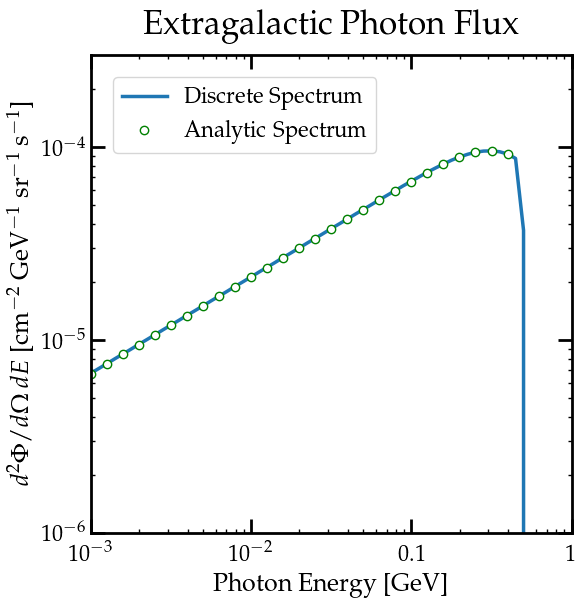

In [14]:
plt.figure() 

plt.loglog()

discrete_spec, = plt.plot(
    obs_photon_flux.eng, obs_photon_flux.dNdE, label='Discrete Spectrum'
)

dNdE_analytic = analytic_flux(obs_photon_flux.eng)

analytic_spec, = plt.plot(
    obs_photon_flux.eng, dNdE_analytic, 'go', marker='o', markersize='6', 
    markerfacecolor='w', markevery=2,
    label='Analytic Spectrum'
)

plt.legend(handles=[discrete_spec, analytic_spec])


plt.title('Extragalactic Photon Flux')
plt.xlabel('Photon Energy [GeV]')
plt.ylabel(r'$d^2\Phi/d\Omega\, dE$ [cm$^{-2}$ GeV$^{-1}$ sr$^{-1}$ s$^{-1}$]')
plt.axis([1e-3, 1, 1e-6, 3e-4])

[*Spectra.sum_specs()*](https://darkhistory.readthedocs.io/en/latest/_autosummary/darkhistory/spec/spectra/darkhistory.spec.spectra.Spectra.html?highlight=spectra#darkhistory.spec.spectra.Spectra.sum_specs) can also be called with an argument specifying some weight to be assigned to each of the spectra. So the preceding analysis could have been done using the following code:

```python
# Create the list of Spectrum objects. 
spec_arr = [
    spectools.rebin_N_arr(np.array([2/rs]), np.array([mDM/2]), eng)
    for rs in rs_arr
           ]

# Assign the correct redshift to each of the Spectrum objects. 
# The first Spectrum object is assigned the largest redshift.
for spec,rs in zip(spec_arr,rs_arr):
    spec.rs = rs
    # Redshifting
    spec.redshift(1)
    
photon_flux_2 = Spectra(spec_arr)
# Weighted sum
obs_photon_flux_2 = photon_flux_2.sum_specs(fac*prefac)
```

## Interpolation and Plotting

The two key advantages of using the  object is interpolation and plotting. Given a [*Spectra*](https://darkhistory.readthedocs.io/en/latest/_autosummary/darkhistory/spec/spectra/darkhistory.spec.spectra.Spectra.html) object with spectra corresponding to different redshifts, [*Spectra.at_rs()*](https://darkhistory.readthedocs.io/en/latest/_autosummary/darkhistory/spec/spectra/darkhistory.spec.spectra.Spectra.html?highlight=spectra#darkhistory.spec.spectra.Spectra.at_rs) takes in an array of new redshifts, and performs a linear interpolation over the whole [*Spectra*](https://darkhistory.readthedocs.io/en/latest/_autosummary/darkhistory/spec/spectra/darkhistory.spec.spectra.Spectra.html) to give you a new [*Spectra*](https://darkhistory.readthedocs.io/en/latest/_autosummary/darkhistory/spec/spectra/darkhistory.spec.spectra.Spectra.html) object, with spectra at the new redshifts. 

To demonstrate this, we return to the CMB energy spectrum once again, and generate a [*Spectra*](https://darkhistory.readthedocs.io/en/latest/_autosummary/darkhistory/spec/spectra/darkhistory.spec.spectra.Spectra.html) object storing the number of CMB photons per unit energy per co-moving volume at several different redshifts. We do this by initializing the [*Spectra*](https://darkhistory.readthedocs.io/en/latest/_autosummary/darkhistory/spec/spectra/darkhistory.spec.spectra.Spectra.html) object with an empty array, and then using [*Spectra.append()*](https://darkhistory.readthedocs.io/en/latest/_autosummary/darkhistory/spec/spectra/darkhistory.spec.spectra.Spectra.html?highlight=spectra#darkhistory.spec.spectra.Spectra.append) to add more [*Spectrum*](https://darkhistory.readthedocs.io/en/development/_autosummary/darkhistory/spec/spectrum/darkhistory.spec.spectrum.Spectrum.html) objects to it. 

In [15]:
# Define the output energy abscissa. 
eng = 10**((np.arange(120)-90)*(1/10))
# Define the redshift abscissa.
rs_arr = 1+np.arange(100)

# Analytic CMB spectrum

CMB_specs = Spectra([])
for rs in rs_arr:
    spec = spectools.discretize(eng, phys.CMB_spec, phys.TCMB(1)*rs)
    # Change the result to per co-moving volume
    spec *= rs**3
    spec.rs = rs
    CMB_specs.append(spec)

We can interpolate to get the spectrum at any intermediate redshift within the abscissa of the [*Spectra*](https://darkhistory.readthedocs.io/en/latest/_autosummary/darkhistory/spec/spectra/darkhistory.spec.spectra.Spectra.html) object, using [*Spectra.at_rs()*](https://darkhistory.readthedocs.io/en/latest/_autosummary/darkhistory/spec/spectra/darkhistory.spec.spectra.Spectra.html?highlight=spectra#darkhistory.spec.spectra.Spectra.at_rs). This returns a new [*Spectra*](https://darkhistory.readthedocs.io/en/latest/_autosummary/darkhistory/spec/spectra/darkhistory.spec.spectra.Spectra.html) object with just the spectra at the specified redshift. The interpolation is done in log redshift. 

In [16]:
rs_selected = np.array([2.495, 30.4903, 99.910])
CMB_specs_selected = CMB_specs.at_rs(rs_selected)
print('CMB_specs_selected has the following redshift abscissa: ', 
     CMB_specs_selected.rs)

CMB_specs_selected has the following redshift abscissa:  [ 2.495  30.4903 99.91  ]


Let's plot the result. [*Spectra*](https://darkhistory.readthedocs.io/en/latest/_autosummary/darkhistory/spec/spectra/darkhistory.spec.spectra.Spectra.html) includes a function [*Spectra.plot()*](https://darkhistory.readthedocs.io/en/latest/_autosummary/darkhistory/spec/spectra/darkhistory.spec.spectra.Spectra.html), meant to make plotting of multiple spectra at the same time easy. The axis of the plot is passed to the function, and keyword arguments to `matplotlib` can simply be passed to the function to change the plot properties. 

For a start, we call [*Spectra.plot()*](https://darkhistory.readthedocs.io/en/latest/_autosummary/darkhistory/spec/spectra/darkhistory.spec.spectra.Spectra.html) for `CMB_specs_selected` by passing just the axis and keyword arguments for plotting: this simply plots every spectrum inside it (**NB: Doing this for a large [*Spectra*](https://darkhistory.readthedocs.io/en/latest/_autosummary/darkhistory/spec/spectra/darkhistory.spec.spectra.Spectra.html) object will take a long time!**). We overlay the analytic result for comparison.

[1e-08, 100, 1e-07, 1e+17]

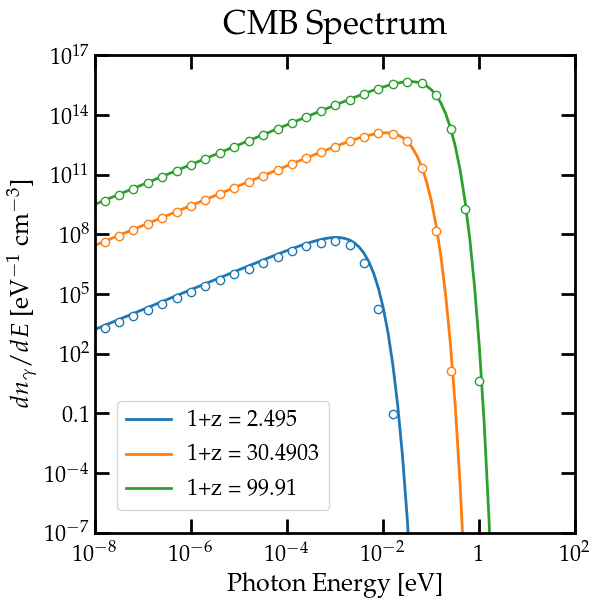

In [17]:
analytic_spec = [
    phys.CMB_spec(
        CMB_specs_selected.eng, phys.TCMB(1)*rs
    )*rs**3 for rs in rs_selected
]

ax = plt.subplot(1,1,1)
plt.rc('text', usetex=True)

spectra_plot = CMB_specs_selected.plot(ax, linewidth=2)

plt.gca().set_prop_cycle(None)

analytic_plot = [
    plt.plot(
        CMB_specs_selected.eng, spec, 'o',
        marker='o', markersize='6', markevery=3, markerfacecolor='w'
    ) for spec in analytic_spec
]

plt.legend(spectra_plot, ('1+z = 2.495','1+z = 30.4903', '1+z = 99.91'))


ax.set_xscale('log')
ax.set_yscale('log')


plt.title('CMB Spectrum')
plt.xlabel('Photon Energy [eV]')
plt.ylabel(r'$dn_\gamma/dE$ [eV$^{-1}$ cm$^{-3}$]')
plt.axis([1e-8, 100, 1e-7, 1e17])

[*Spectra.plot()*](https://darkhistory.readthedocs.io/en/latest/_autosummary/darkhistory/spec/spectra/darkhistory.spec.spectra.Spectra.html) can be used to plot selected spectra, for example at arbitrary redshifts within the redshift abscissa. Linear interpolation is done automatically to pick out the correct spectra. 

[*Spectra.plot()*](https://darkhistory.readthedocs.io/en/latest/_autosummary/darkhistory/spec/spectra/darkhistory.spec.spectra.Spectra.html) also takes the argument `fac`, which allows the user to multiply the spectra by some arbitrary factor.

[1e-08, 100, 1e-07, 1e+17]

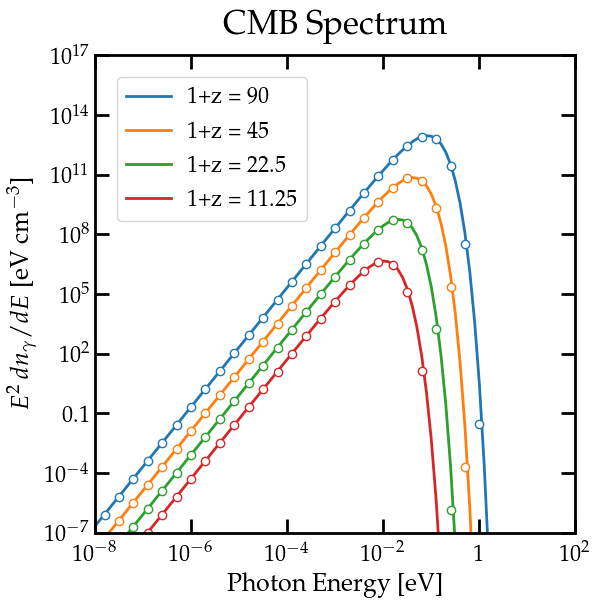

In [18]:
plt.figure()

plt.loglog()

ax = plt.gca()

rs_to_plot = np.array([90, 45, 22.5, 11.25])
spectra_plot = CMB_specs.plot(ax, ind=rs_to_plot, indtype='rs', fac=CMB_specs.eng**2, linewidth=2)

plt.legend(spectra_plot, ('1+z = 90','1+z = 45', '1+z = 22.5', '1+z = 11.25'))

plt.gca().set_prop_cycle(None)

analytic_spec = [
    phys.CMB_spec(
        CMB_specs.eng, phys.TCMB(1)*rs
    )*CMB_specs.eng**2*rs**3 for rs in rs_to_plot
]

analytic_plot = [
    plt.plot(
        CMB_specs_selected.eng, spec, 'o',
        marker='o', markersize='6', markevery=3, markerfacecolor='w'
    ) for spec in analytic_spec
]


plt.title('CMB Spectrum')
plt.xlabel('Photon Energy [eV]')
plt.ylabel(r'$E^2 \, dn_\gamma/dE$ [eV cm$^{-3}$]')
plt.axis([1e-8, 100, 1e-7, 1e17])

We can also make plots without interpolation, by selecting the spectra stored in the `Spectra` object by specifying the index. There are many different ways to specify what to plot, and the user should refer to the documentation to find out more. Below, we plot the spectra between two indices in steps: 

[1e-08, 100, 100000.0, 1e+17]

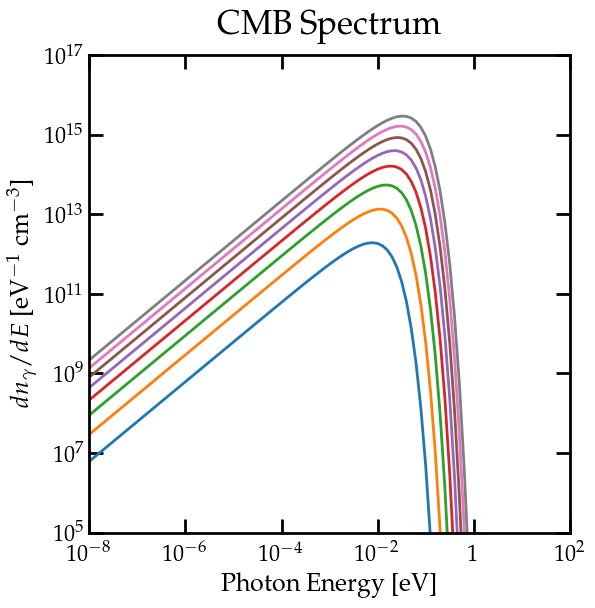

In [19]:
plt.figure()

ax = plt.gca()
ax.loglog()

# Plots index 20 to 99, steps of 10 (i.e. 20, 30, 40, 50, 60, 70, 80, 90)
spectra_plot = CMB_specs.plot(ax, ind=(20,100), step=10, indtype='ind', linewidth=2)

plt.title('CMB Spectrum')
plt.xlabel('Photon Energy [eV]')
plt.ylabel(r'$dn_\gamma/dE$ [eV$^{-1}$ cm$^{-3}$]')
plt.axis([1e-8, 100, 1e5, 1e17])

## `Spectra` - Sums, Integration over each Spectrum

Integration over each spectrum can be done using [*Spectra.integrate_each_spec()*](https://darkhistory.readthedocs.io/en/latest/_autosummary/darkhistory/spec/spectra/darkhistory.spec.spectra.Spectra.html?highlight=spectra#darkhistory.spec.spectra.Spectra.integrate_each_spec), with the result being an array. There are many reasons to perform an integration over each spectrum; here, we will show only a trivial example, integrating over the spectrum to get the total number. To do this, we use [*Spectra.integrate_each_spec()*](https://darkhistory.readthedocs.io/en/latest/_autosummary/darkhistory/spec/spectra/darkhistory.spec.spectra.Spectra.html?highlight=spectra#darkhistory.spec.spectra.Spectra.integrate_each_spec) with a weight given by $E \, d \log E$. Like [*Spectrum*](https://darkhistory.readthedocs.io/en/latest/_autosummary/darkhistory/spec/spectrum/darkhistory.spec.spectrum.Spectrum.html), [*Spectra*](https://darkhistory.readthedocs.io/en/latest/_autosummary/darkhistory/spec/spectra/darkhistory.spec.spectra.Spectra.html) also has [*Spectra.totN()*](https://darkhistory.readthedocs.io/en/latest/_autosummary/darkhistory/spec/spectra/darkhistory.spec.spectra.Spectra.html?highlight=spectra#darkhistory.spec.spectra.Spectra.totN) and [*Spectra.toteng()*](https://darkhistory.readthedocs.io/en/latest/_autosummary/darkhistory/spec/spectra/darkhistory.spec.spectra.Spectra.html?highlight=spectra#darkhistory.spec.spectra.Spectra.toteng) functions, which return an array of numbers instead, one for each spectrum. 

In [20]:
log_bin_width = spectools.get_log_bin_width(CMB_specs.eng)
total_1 = CMB_specs.integrate_each_spec(CMB_specs.eng * log_bin_width)
total_2 = CMB_specs.totN()
print('Are the two results equal (up to floating point accuracy)?')
print(np.all(np.isclose(total_1, total_2, rtol=1e-15)))

Are the two results equal (up to floating point accuracy)?
True
